In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
data_test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

data_train.head()

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred,prob,prob_iso,pred_iso
1995-04-12,0.007792,0,1.0,0.011444,1,0.007792,0.002082,-0.032066,0.0,0,0.420654,0.359955,0
1995-04-13,0.011444,0,0.0,-0.012698,1,0.011444,0.007792,0.002082,0.0,1,0.549950,0.558766,1
1995-04-14,-0.012698,0,0.0,-0.013694,0,-0.012698,0.011444,0.007792,0.0,0,0.000000,0.000000,0
1995-04-15,-0.013694,0,1.0,0.010499,0,-0.000000,-0.012698,0.011444,0.0,0,0.000000,0.000000,0
1995-04-16,0.010499,0,1.0,0.008869,1,0.000000,-0.013694,-0.012698,0.0,1,0.511305,0.436468,0


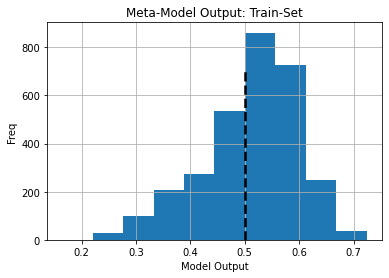

In [4]:
# Subset on trades
data = data_train[data_train['pmodel'] == 1]

# Show hist of model output
data['prob'].hist()
plt.title('Meta-Model Output: Train-Set')
plt.xlabel('Model Output')
plt.ylabel('Freq')

plt.vlines(x=0.5, ymin=0, ymax=700, colors='Black', linestyles='--', linewidth=2.5)
plt.show()

In [4]:
# Get the expected win and loss %
true_pos = data[(data['pred_regime'] == 1) & (data['target']==1)]
false_pos = data[(data['pred_regime'] == 1) & (data['target']==0)]

exp_gain = true_pos['target_rets'].mean()
exp_loss = false_pos['target_rets'].mean()

print('E[gain]:', np.round(exp_gain, 3))
print('E[loss]:', np.round(exp_loss, 3))

# Define Kelly Criterion
def kelly(p, win, loss):
    return (p / abs(loss)) - ((1-p)/win)

E[gain]: 0.014
E[loss]: -0.012


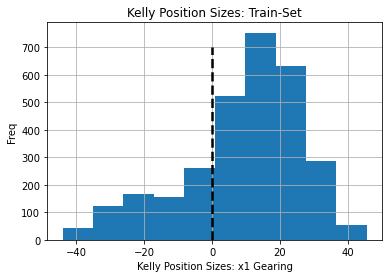

Max level: 45.55


In [5]:
# Compute position sizes
b = kelly(p=data['prob_regime'], win=exp_gain, loss=exp_loss)

b.hist()
plt.title('Kelly Position Sizes: Train-Set')
plt.xlabel('Kelly Position Sizes: x1 Gearing')
plt.ylabel('Freq')
plt.vlines(x=0.0, ymin=0, ymax=700, colors='Black', linestyles='--', linewidth=2.5)
plt.show()

print('Max level:', np.round(b.max(), 2))

In [6]:
kelly(p=0.468, win=0.014, loss=0.012)

1.0

At p=0.468 the position size jumps to 1. Thus all the prob higher than 0.5 will just be full 1x invested. Not very useful. 

---

# Frequentist analog

Lets see if we can map the baysian probability with a frequentist one.

* Manual mapping
* Model calibration
* Lit review


## Put it into deciles and then check how often that decile occurred

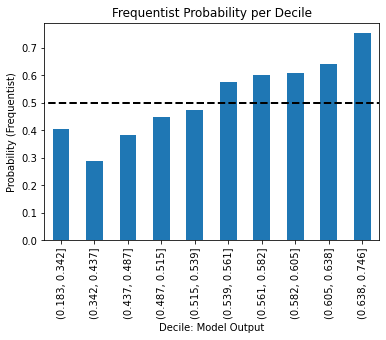

In [7]:
data['cat'], b, = pd.qcut(data['prob_regime'], q=10, retbins=True)

# Compute probability per decile
acc = data.groupby(['cat', 'target']).count()['prob_regime'].unstack()
accuracy = acc[1] / acc.sum(axis=1)

# Plot probability of true, per decile
accuracy.plot.bar()
plt.title('Frequentist Probability per Decile')
plt.xlabel('Decile: Model Output')
plt.ylabel('Probability (Frequentist)')
plt.hlines(y=0.5, xmin=-1, xmax=accuracy.shape[0], colors='Black', linestyles='--', linewidth=2)
plt.show()

In [8]:
# Kelly is too sensitive, any p > 0.467 = 1x gearing or greater
kelly(p=0.467, win=exp_gain, loss=exp_loss)

1.0651594516740914

Note: Each decile will have its own expected win / loss

In [9]:
exp_wins = data[data['target_rets']>0].groupby(['cat'])['target_rets'].mean()
exp_losses = data[data['target_rets']<0].groupby(['cat'])['target_rets'].mean()

In [10]:
pstore, sstore = [], []
for i in range(0, 10):
    indx = i
    b = kelly(accuracy[indx], exp_wins[indx], exp_losses[indx])
    p = np.round(accuracy[indx], 3)
    print('P:', p, '\tW:', np.round(exp_wins[indx], 3), '\tL:', np.round(exp_losses[indx], 3))
    scaled = np.round(np.min([np.max([b, 0]), 1]), 2)
    print('Size', np.round(b, 2), '\tScaled', scaled) 
    print('------------------------------------------\n')
    pstore.append(p)
    sstore.append(scaled)

P: 0.407 	W: 0.012 	L: -0.013
Size -17.59 	Scaled 0.0
------------------------------------------

P: 0.288 	W: 0.01 	L: -0.016
Size -54.51 	Scaled 0.0
------------------------------------------

P: 0.381 	W: 0.012 	L: -0.015
Size -27.16 	Scaled 0.0
------------------------------------------

P: 0.45 	W: 0.012 	L: -0.015
Size -16.33 	Scaled 0.0
------------------------------------------

P: 0.475 	W: 0.012 	L: -0.012
Size -4.1 	Scaled 0.0
------------------------------------------

P: 0.575 	W: 0.012 	L: -0.012
Size 11.03 	Scaled 1.0
------------------------------------------

P: 0.6 	W: 0.014 	L: -0.011
Size 25.34 	Scaled 1.0
------------------------------------------

P: 0.609 	W: 0.014 	L: -0.01
Size 29.62 	Scaled 1.0
------------------------------------------

P: 0.642 	W: 0.014 	L: -0.01
Size 35.63 	Scaled 1.0
------------------------------------------

P: 0.753 	W: 0.016 	L: -0.011
Size 52.75 	Scaled 1.0
------------------------------------------



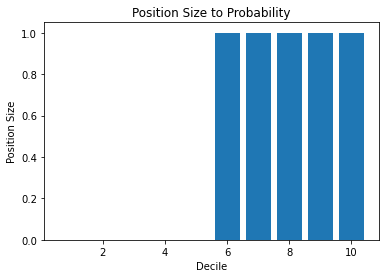

In [11]:
# Plot position sizes for deciles
plt.bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], sstore)
plt.title('Position Size to Probability')
plt.ylabel('Position Size')
plt.xlabel('Decile')
plt.show()

---
## Probability Calibration

Readings:
* https://towardsdatascience.com/calibrating-classifiers-559abc30711a


In [12]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

Min: 0.18 	Max: 0.75 



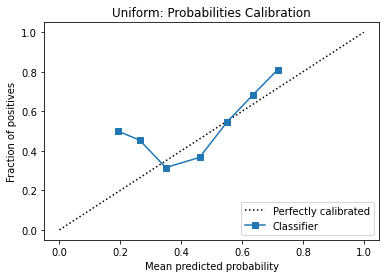

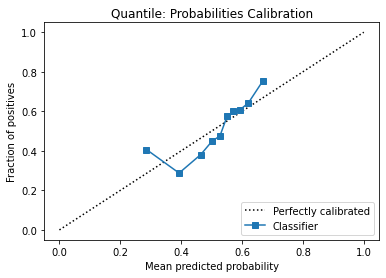

In [13]:
bins = 10
print('Min:', np.round(data['prob_regime'].min(), 2), '\tMax:', np.round(data['prob_regime'].max(), 2), '\n')

CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], n_bins=bins, strategy='uniform')
plt.title('Uniform: Probabilities Calibration')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], n_bins=bins, strategy='quantile')
plt.title('Quantile: Probabilities Calibration')
plt.show()

* Why do many models produce such biased probability estimates, especially for very low and high values?
* Reasons are slightly different for each model depending on how it works.
* A lot of other classifiers, such as naive Bayes, SVMs, or decision trees will also produce an S-shaped calibration curve.
* **The general reason for this is that most classification models optimize for and are scored by binary metrics.**

Notes:
* Logistic regression is a rare beast that actually produces calibrated probabilities.
    * The secret behind it is that it optimizes for log-odds, which makes probabilities actually present in the model’s cost function.
* Approaches:
    * Platt-scaling (Sigmoid)
        * Platt-scaling is better at correcting S-shaped probability estimates
    * Isotonic regression
        * Handle any bias shape but at the cost of being prone to overfitting.
        * In practice, recommend going for Platt-scaling, unless you see it not working well and your data set is large.
* The calibration model should be based on different data than that to which a random forest was fit. 
    * Hence, you either need a separate validation set
    * Or you can simply use cross-validation
    
* **CalibratedClassifierCV**


### Calibration Conclusion 
* Many classification models, such as random forest, decision trees, support vector machines, or naive Bayes return biased probability estimates of class membership.
* These biased probabilities can be used for thresholding, but cannot be held as certainty measures. For instance, if according to such a model, one sample has a probability of 70% of belonging to some class, and another one has 50%, then the former is indeed more likely to belong to this class, but the probability of this being true need not in reality amount to 70%.
* This is especially true for very high and low predicted probability: if the model predicts 2%, the real probability is likely more than this; if it predicts 97%, it’s typically less.
* The process of fixing the biased probabilities is known as calibration. It boils down to training a calibrating classifier on top of the initial model. Two popular calibration models are logistic and isotonic regression.
* Training a calibration model requires having a separate validation set or performing cross-validation to avoid overfitting.
* It’s all very easy to do in scikit-learn.

---

## Test Calibration algos

In [14]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
X_train_regime = data_train[['rets', 'rets2', 'rets3', 'regime']][data_train['pmodel']==1]
X_test_regime = data_test[['rets', 'rets2', 'rets3', 'regime']][data_test['pmodel']==1]
y_train = data_train['target'][data_train['pmodel']==1]
y_test = data_test['target'][data_test['pmodel']==1]

In [16]:
scaler = StandardScaler()
X_train_regime_scaled = scaler.fit_transform(X_train_regime)
X_test_regime_scaled = scaler.transform(X_test_regime)

In [82]:
# Train model (FP)
meta_model_regime = LogisticRegression(random_state=0, penalty='none')
# meta_model_regime.fit(X_train_regime_scaled, y_train)

In [83]:
# Apply calibration
# {'sigmoid', 'isotonic'}
calibrated_model_sigmoid = CalibratedClassifierCV(base_estimator=meta_model_regime, method='sigmoid', cv=5, n_jobs=-1)
calibrated_model_sigmoid.fit(X_train_regime_scaled, y_train)

calibrated_model_isotonic = CalibratedClassifierCV(base_estimator=meta_model_regime, method='isotonic', cv=5, n_jobs=-1)
calibrated_model_isotonic.fit(X_train_regime_scaled, y_train)

probs_sigmoid = calibrated_model_sigmoid.predict_proba(X_train_regime_scaled)[:, 1]
probs_isotonic = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]

---

In [ ]:
# Get iso model scores
probs_isotonic = calibrated_model_isotonic.predict_proba(X_train_regime_scaled)[:, 1]

# Get base model scores
base_scores = np.array([cmodel.base_estimator.predict_proba(X_train_regime_scaled)[:, 1]
                        for cmodel in calibrated_model_isotonic.calibrated_classifiers_]).mean(axis=0)

# Check that the base model and calibrated models align
assert (base_scores.shape == probs_isotonic.shape)

---

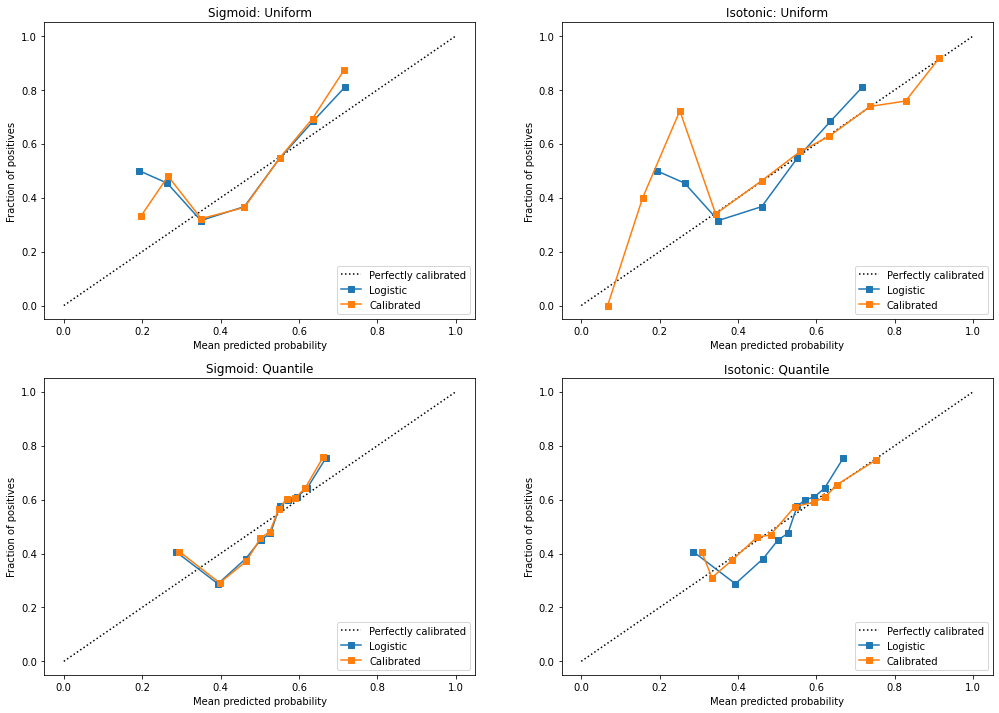

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(17, 12))

# 1st
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], ax=axs[0, 0], n_bins=bins, strategy='uniform')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_sigmoid, ax=axs[0, 0], n_bins=bins, strategy='uniform')
axs[0, 0].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[0, 0].set_title('Sigmoid: Uniform')

# 2nd
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], ax=axs[1, 0], n_bins=bins, strategy='quantile')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_sigmoid, ax=axs[1, 0], n_bins=bins, strategy='quantile')
axs[1, 0].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[1, 0].set_title('Sigmoid: Quantile')

# 3rd
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], ax=axs[0, 1], n_bins=bins, strategy='uniform')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_isotonic, ax=axs[0, 1], n_bins=bins, strategy='uniform')
axs[0, 1].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[0, 1].set_title('Isotonic: Uniform')

# 4th
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=data['prob_regime'], ax=axs[1, 1], n_bins=bins, strategy='quantile')
CalibrationDisplay.from_predictions(y_true=data['target'], y_prob=probs_isotonic, ax=axs[1, 1], n_bins=bins, strategy='quantile')
axs[1, 1].legend(['Perfectly calibrated', 'Logistic', 'Calibrated'], loc='lower right')
axs[1, 1].set_title('Isotonic: Quantile')

plt.show()

In [20]:
data['probs_isotonic'] = probs_isotonic
data

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime,pred_regime,prob_regime,meta_rets_regime,cat,probs_isotonic
1995-01-22,0.024847,0,1.0,0.029305,1,0.000000,-0.030059,0.001748,0.0,1.0,0.592489,0.000000,"(0.582, 0.605]",0.617378
1995-01-23,0.029305,0,0.0,-0.003118,1,0.029305,0.024847,-0.030059,0.0,0.0,0.438545,0.029305,"(0.437, 0.487]",0.370995
1995-01-28,0.014554,0,1.0,0.021183,1,0.000000,-0.010735,-0.018585,0.0,0.0,0.489751,0.000000,"(0.487, 0.515]",0.433661
1995-01-29,0.021183,0,1.0,0.021976,1,0.021183,0.014554,-0.010735,0.0,1.0,0.520295,0.000000,"(0.515, 0.539]",0.483861
1995-01-30,0.021976,0,1.0,0.015668,1,0.021976,0.021183,0.014554,0.0,1.0,0.626580,0.021976,"(0.605, 0.638]",0.639011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-20,0.007911,0,0.0,-0.012933,1,0.000000,-0.008262,-0.007941,0.0,1.0,0.530379,0.000000,"(0.515, 0.539]",0.472978
2011-05-23,0.000580,0,0.0,-0.006792,1,0.000000,-0.002575,-0.012933,0.0,1.0,0.500909,0.000000,"(0.487, 0.515]",0.464035
2011-05-29,0.002540,0,1.0,0.008013,1,0.000000,-0.000871,-0.006436,0.0,1.0,0.530243,0.000000,"(0.515, 0.539]",0.472978
2011-05-30,0.008013,0,1.0,0.023775,1,0.008013,0.002540,-0.000871,0.0,1.0,0.557406,0.008013,"(0.539, 0.561]",0.572039


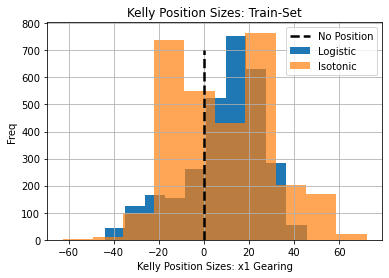

Max level: 45.55 	 72.28


In [21]:
# Compute position sizes
b = kelly(p=data['prob_regime'], win=exp_gain, loss=exp_loss)
c = kelly(p=data['probs_isotonic'], win=exp_gain, loss=exp_loss)

b.hist()
plt.title('Kelly Position Sizes: Train-Set')
plt.xlabel('Kelly Position Sizes: x1 Gearing')
plt.ylabel('Freq')
plt.vlines(x=0.0, ymin=0, ymax=700, colors='Black', linestyles='--', linewidth=2.5)

c.hist(alpha=0.7)
plt.legend(['No Position', 'Logistic', 'Isotonic'])

plt.show()

print('Max level:', np.round(b.max(), 2), '\t', np.round(c.max(), 2))

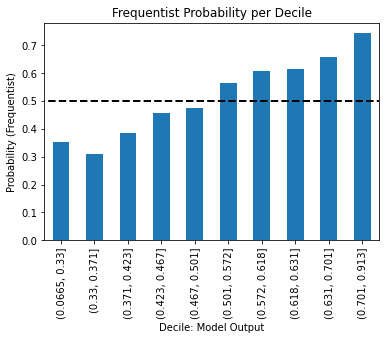

In [22]:
data['cat_iso'], _, = pd.qcut(data['probs_isotonic'], q=10, retbins=True)

# Compute probability per decile
acc = data.groupby(['cat_iso', 'target']).count()['probs_isotonic'].unstack()
accuracy_iso = acc[1] / acc.sum(axis=1)

# Plot probability of true, per decile
accuracy_iso.plot.bar()
plt.title('Frequentist Probability per Decile')
plt.xlabel('Decile: Model Output')
plt.ylabel('Probability (Frequentist)')
plt.hlines(y=0.5, xmin=-1, xmax=accuracy_iso.shape[0], colors='Black', linestyles='--', linewidth=2)
plt.show()

In [23]:
exp_wins_i = data[data['target_rets']>0].groupby(['cat_iso'])['target_rets'].mean()
exp_losses_i = data[data['target_rets']<0].groupby(['cat_iso'])['target_rets'].mean()

In [24]:
pstore, sstorei = [], []
for i in range(0, 10):
    indx = i
    b = kelly(accuracy[indx], exp_wins[indx], exp_losses[indx])
    bi = kelly(accuracy_iso[indx], exp_wins[indx], exp_losses[indx])
    p = np.round(accuracy[indx], 3)
    pi = np.round(accuracy_iso[indx], 3)
    print('P:', p, 'Pi:', pi, '\tW:', np.round(exp_wins_i[indx], 3), '\tL:', np.round(exp_losses_i[indx], 3))
    scaled = np.round(np.min([np.max([b, 0]), 1]), 2)
    print('Size', np.round(b, 2), '\tScaled', scaled) 
    print('------------------------------------------\n')
    pstore.append(p)
    sstorei.append(scaled)

P: 0.407 Pi: 0.352 	W: 0.011 	L: -0.015
Size -17.59 	Scaled 0.0
------------------------------------------

P: 0.288 Pi: 0.31 	W: 0.01 	L: -0.015
Size -54.51 	Scaled 0.0
------------------------------------------

P: 0.381 Pi: 0.385 	W: 0.012 	L: -0.015
Size -27.16 	Scaled 0.0
------------------------------------------

P: 0.45 Pi: 0.459 	W: 0.011 	L: -0.014
Size -16.33 	Scaled 0.0
------------------------------------------

P: 0.475 Pi: 0.474 	W: 0.012 	L: -0.013
Size -4.1 	Scaled 0.0
------------------------------------------

P: 0.575 Pi: 0.564 	W: 0.013 	L: -0.013
Size 11.03 	Scaled 1.0
------------------------------------------

P: 0.6 Pi: 0.609 	W: 0.014 	L: -0.009
Size 25.34 	Scaled 1.0
------------------------------------------

P: 0.609 Pi: 0.617 	W: 0.013 	L: -0.011
Size 29.62 	Scaled 1.0
------------------------------------------

P: 0.642 Pi: 0.659 	W: 0.014 	L: -0.011
Size 35.63 	Scaled 1.0
------------------------------------------

P: 0.753 Pi: 0.744 	W: 0.016 	L: -0.011

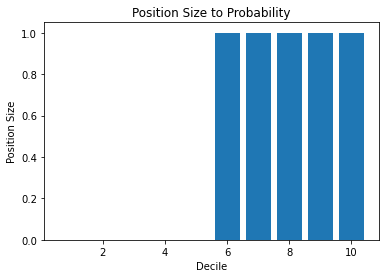

In [25]:
# Plot position sizes for deciles
plt.bar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], sstorei)
plt.title('Position Size to Probability')
plt.ylabel('Position Size')
plt.xlabel('Decile')
plt.show()

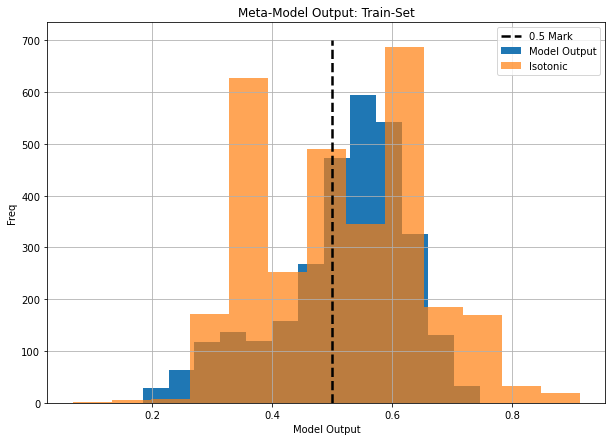

In [26]:
# Show hist of model output
plt.figure(figsize=(10, 7))
data['prob_regime'].hist(bins=13)
data['probs_isotonic'].hist(alpha=0.7, bins=13)
plt.title('Meta-Model Output: Train-Set')
plt.xlabel('Model Output')
plt.ylabel('Freq')
plt.vlines(x=0.5, ymin=0, ymax=700, colors='Black', linestyles='--', linewidth=2.5)
plt.legend(['0.5 Mark', 'Model Output', 'Isotonic'])
plt.show()

---
# Position Sizing

In [ ]:
data_train_p = data_train_set[data_train_set['pmodel'] == 1]
data_test_p = data_test_set[data_test_set['pmodel'] == 1]

In [27]:
prob = data['prob_regime']
prob_iso = data['probs_isotonic']

target_return_train = data['target_rets']

## Meta-Labeling on Probs

In [28]:
# Daily data update with position sizes
data_train['meta_bet_size'] = 0
data_train['meta_bet_size_iso'] = 0
data_train.loc[data.index, 'meta_bet_size'] = prob
data_train.loc[data.index, 'meta_bet_size_iso'] = prob_iso

In [29]:
# Backtest
data_train['meta_rets'] = (data_train['meta_bet_size'] * data_train['target_rets']).shift(1)
data_train['meta_iso_rets'] = (data_train['meta_bet_size_iso'] * data_train['target_rets']).shift(1)

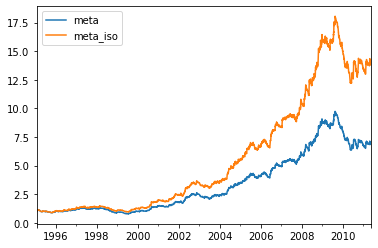

In [30]:
(data_train['meta_rets']+1).cumprod().plot()
(data_train['meta_iso_rets']+1).cumprod().plot()
plt.legend(['meta', 'meta_iso'])
plt.show()

## Linear Dependency Models

In [67]:
# First part - Linear dependency models
# A1 - Linear Scaling

def linear_scaling(prob_train, prob_test):
    bet_sizes = (prob_test - prob_train.min()) / (prob_train.max() - prob_train.min())
    return bet_sizes

In [68]:
# Linear betsizes
bet_sizes_meta = linear_scaling(prob, prob)
bet_sizes_iso = linear_scaling(prob_iso, prob_iso)

# daily data update with position sizes
data_train['lin_bet_size_iso'] = 0
data_train['lin_bet_size_meta'] = 0
data_train.loc[data.index, 'lin_bet_size_iso'] = bet_sizes_iso
data_train.loc[data.index, 'lin_bet_size_meta'] = bet_sizes_meta

In [69]:
# Backtest
data_train['lin_meta_rets'] = (data_train['lin_bet_size_meta'] * data_train['target_rets']).shift(1)
data_train['lin_iso_rets'] = (data_train['lin_bet_size_iso'] * data_train['target_rets']).shift(1)
# data_train.dropna(inplace=True)

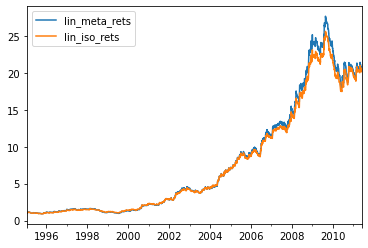

In [70]:
(data_train['lin_meta_rets']+1).cumprod().plot()
(data_train['lin_iso_rets']+1).cumprod().plot()
plt.legend(['lin_meta_rets', 'lin_iso_rets'])
plt.show()

## ECDF

In [60]:
from statsmodels.distributions.empirical_distribution import ECDF

In [61]:
ecdf = ECDF(prob)
ecdf_iso = ECDF(prob_iso)

# ECDF Position Sizing
ecdf_size = prob.apply(lambda x: ecdf(x))
ecdf_size_iso = prob_iso.apply(lambda x: ecdf_iso(x))

# Daily data update with position sizes
data_train['ecdf_size'] = 0
data_train['ecdf_size_iso'] = 0
data_train.loc[data.index, 'ecdf_size'] = ecdf_size
data_train.loc[data.index, 'ecdf_size_iso'] = ecdf_size_iso

# Backtest
data_train['ecdf_rets'] = (data_train['ecdf_size'] * data_train['target_rets']).shift(1)
data_train['ecdf_iso_rets'] = (data_train['ecdf_size_iso'] * data_train['target_rets']).shift(1)
# data_train.dropna(inplace=True)

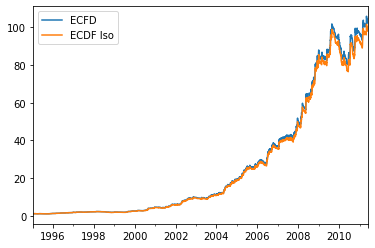

In [62]:
(data_train['ecdf_rets']+1).cumprod().plot()
(data_train['ecdf_iso_rets']+1).cumprod().plot()
plt.legend(['ECFD', 'ECDF Iso'])
plt.show()

* **This seems very high**

## Lopez de Prado Sizing

In [38]:
from scipy.stats import norm

In [39]:
def de_prado_bet_size(prob_series, clip=True):

    # Getting max value from training set
    num_classes = 2
    dp_sizes = (prob_series - 1 / num_classes) / ((prob_series * (1 - prob_series)) ** 0.5)
    dp_t_sizes = dp_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)
    dp_bet_sizes = dp_t_sizes / dp_sizes.max()
    
    if clip: 
        dp_bet_sizes[dp_bet_sizes > 1.0] = 1
        dp_bet_sizes[dp_bet_sizes < 0] = 0
        
    return dp_bet_sizes

In [40]:
dp_size = de_prado_bet_size(prob, clip=True)
dp_size_iso = de_prado_bet_size(prob_iso, clip=True)

# Assign position sizes
data_train['dp_size'] = 0
data_train.loc[data.index, 'dp_size'] = dp_size
data_train['dp_size_iso'] = 0
data_train.loc[data.index, 'dp_size_iso'] = dp_size_iso

# Get daily rets
data_train['dp_rets'] = (data_train['dp_size'] * data_train['target_rets']).shift(1)
data_train['dp_rets_iso'] = (data_train['dp_size_iso'] * data_train['target_rets']).shift(1)


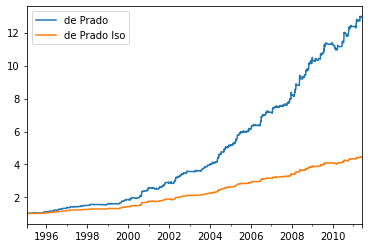

In [41]:
(data_train['dp_rets']+1).cumprod().plot()
(data_train['dp_rets_iso']+1).cumprod().plot()
plt.legend(['de Prado', 'de Prado Iso'])
plt.show()

## Sigmoid Optimal Fit

In [42]:
from scipy.optimize import minimize

In [43]:
def target(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    
    # Backtest + sharpe ratio
    rets = f(prob) * target_return_train
    sharp_ratio = np.mean(rets) / np.std(rets)
    return - sharp_ratio

def target_iso(x):

    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    values = f(prob_iso) * target_return_train
    return - np.mean(values) / np.std(values)

In [44]:
x0 = np.array([1, 0])
res = minimize(target, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': False})
model = res.x
scaled = 1 / (1 + np.exp(-model[0] * prob - model[1]))

x0 = np.array([1, 0])
res = minimize(target_iso, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': False})
model = res.x
scaled_iso = 1 / (1 + np.exp(-model[0] * prob_iso - model[1]))

In [45]:
# Assign position sizes
data_train['sop_size'] = 0
data_train.loc[data.index, 'sop_size'] = scaled
data_train['sop_size_iso'] = 0
data_train.loc[data.index, 'sop_size_iso'] = scaled_iso

# Get daily rets
data_train['sop_rets'] = (data_train['sop_size'] * data_train['target_rets']).shift(1)
data_train['sop_rets_iso'] = (data_train['sop_size_iso'] * data_train['target_rets']).shift(1)

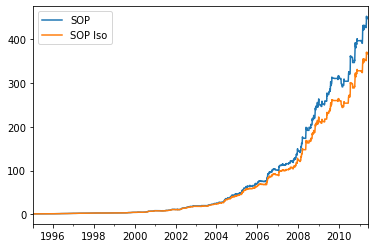

In [46]:
(data_train['sop_rets']+1).cumprod().plot()
(data_train['sop_rets_iso']+1).cumprod().plot()
plt.legend(['SOP', 'SOP Iso'])
plt.show()

## Optimal Linear


In [47]:
def target_linear(x):

    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    
    rets = f(prob) * target_return_train
    if np.std(rets) == 0.0:
        stdev = 1000
    else: 
        stdev = np.std(rets)
    sr = np.mean(rets) / stdev
    return -sr

def target_linear(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_train) * target_train
    # Solve for no positions taken
    stdev = check_std(rets)
    # Sharpe Ratio
    sr = np.mean(rets) / stdev
    return -sr


def target_linear_iso(x):

    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    
    rets = f(prob_iso) * target_return_train
    if np.std(rets) == 0.0:
        stdev = 1000
    else: 
        stdev = np.std(rets)
    sr = np.mean(rets) / stdev
    return -sr

In [48]:
x0 = np.array([1, 0])
res = minimize(target_linear, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
model = res.x
lops_size = model[0] * prob + model[1]

# Clip
lops_size[lops_size > 1] = 1
lops_size[lops_size < 0] = 0

x0 = np.array([1, 0])
res = minimize(target_linear_iso, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': False})
model = res.x
lops_size_iso = model[0] * prob_iso + model[1]

# Clip
lops_size_iso[lops_size_iso > 1] = 1
lops_size_iso[lops_size_iso < 0] = 0

In [49]:
# Assign position sizes
data_train['lops_size'] = 0
data_train.loc[data.index, 'lops_size'] = lops_size
data_train['lops_size_iso'] = 0
data_train.loc[data.index, 'lops_size_iso'] = lops_size_iso

# Get daily rets
data_train['lops_rets'] = (data_train['lops_size'] * data_train['target_rets']).shift(1)
data_train['lops_rets_iso'] = (data_train['lops_size_iso'] * data_train['target_rets']).shift(1)

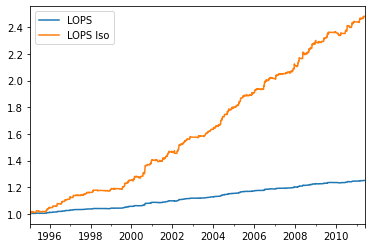

In [50]:
(data_train['lops_rets']+1).cumprod().plot()
(data_train['lops_rets_iso']+1).cumprod().plot()
plt.legend(['LOPS', 'LOPS Iso'])
plt.show()

## Kelly Criterion

In [51]:
# We also need to calculate b here - expected win ratio
winning_trades = data['target_rets'] > 0
loosing_trades = data['target_rets'] < 0
exp_loss = -data.loc[loosing_trades, 'target_rets'].mean()
exp_win = data.loc[winning_trades, 'target_rets'].mean()

print(exp_loss)
print(exp_win)

0.013060868884608296
0.013068285242334254


In [52]:
def clip_kelly(b):
    return np.min([np.max([b, 0]), 1])

kelly_size = kelly(p=data['prob_regime'], win=exp_gain, loss=exp_loss)
kelly_size = kelly_size.apply(clip_kelly)
kelly_size_iso = (prob_iso / exp_loss) + ((prob_iso - 1) / exp_win)
kelly_size_iso = kelly_size_iso.apply(clip_kelly)

In [53]:
# Assign position sizes
data_train['kelly_size'] = 0
data_train.loc[data.index, 'kelly_size'] = kelly_size
data_train['kelly_size_iso'] = 0
data_train.loc[data.index, 'kelly_size_iso'] = kelly_size_iso

# Get daily rets
data_train['kelly_rets'] = (data_train['kelly_size'] * data_train['target_rets']).shift(1)
data_train['kelly_rets_iso'] = (data_train['kelly_size_iso'] * data_train['target_rets']).shift(1)

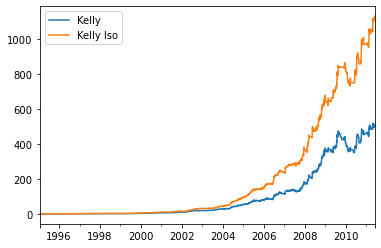

In [54]:
(data_train['kelly_rets']+1).cumprod().plot()
(data_train['kelly_rets_iso']+1).cumprod().plot()
plt.legend(['Kelly', 'Kelly Iso'])
plt.show()

---

# Final Results

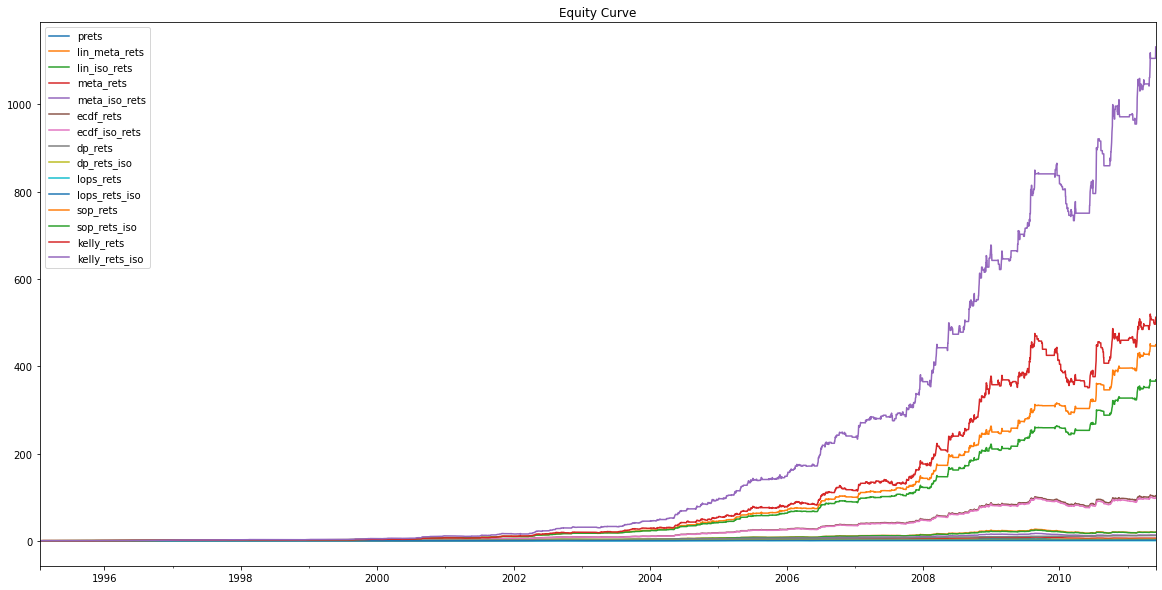

In [64]:
ret_names = ['prets',
             'lin_meta_rets', 'lin_iso_rets',
             'meta_rets', 'meta_iso_rets',
             'ecdf_rets', 'ecdf_iso_rets',
             'dp_rets', 'dp_rets_iso',
             'lops_rets', 'lops_rets_iso',
             'sop_rets', 'sop_rets_iso',
             'kelly_rets', 'kelly_rets_iso']

# Plot returns
(data_train[ret_names] + 1).cumprod().plot(figsize=(20, 10))
plt.title('Equity Curve')
plt.show()

In [66]:
sharpe = data_train[ret_names].mean() / data_train[ret_names].std() * np.sqrt(252)
sharpe

prets             0.313568
lin_meta_rets     1.162054
lin_iso_rets      1.288651
meta_rets         0.883557
meta_iso_rets     1.173796
ecdf_rets         1.882293
ecdf_iso_rets     1.847072
dp_rets           2.462148
dp_rets_iso       2.454941
lops_rets         2.480290
lops_rets_iso     2.532401
sop_rets          2.532871
sop_rets_iso      2.578329
kelly_rets        1.847526
kelly_rets_iso    2.381219
dtype: float64

In [ ]:
lin_rets, lin_iso_rets,
kelly_rets, kelly_iso_rets, 
lop_rets, lop_iso_rets.
dp_rets, dp_iso_rets
ecdf_rets, ecdf_iso_rets
sop_rets, sop_rets_iso
prets = Primary
rets = BAH

In [175]:
def tz(p):
    z = (p-0.5) / np.sqrt(p*(1-p))
    return z

In [180]:
tz(0.9999)

49.99249968748088

C:\Users\jacqu\.conda\envs\mla\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jacqu\.conda\envs\mla\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1995-01-21         NaN
1995-01-22        -inf
1995-01-23   -3.529999
1995-01-24        -inf
1995-01-25        -inf
                ...   
2011-05-27        -inf
2011-05-28        -inf
2011-05-29        -inf
2011-05-30   -4.826745
2011-05-31   -3.739111
Name: kelly_rets, Length: 5975, dtype: float64

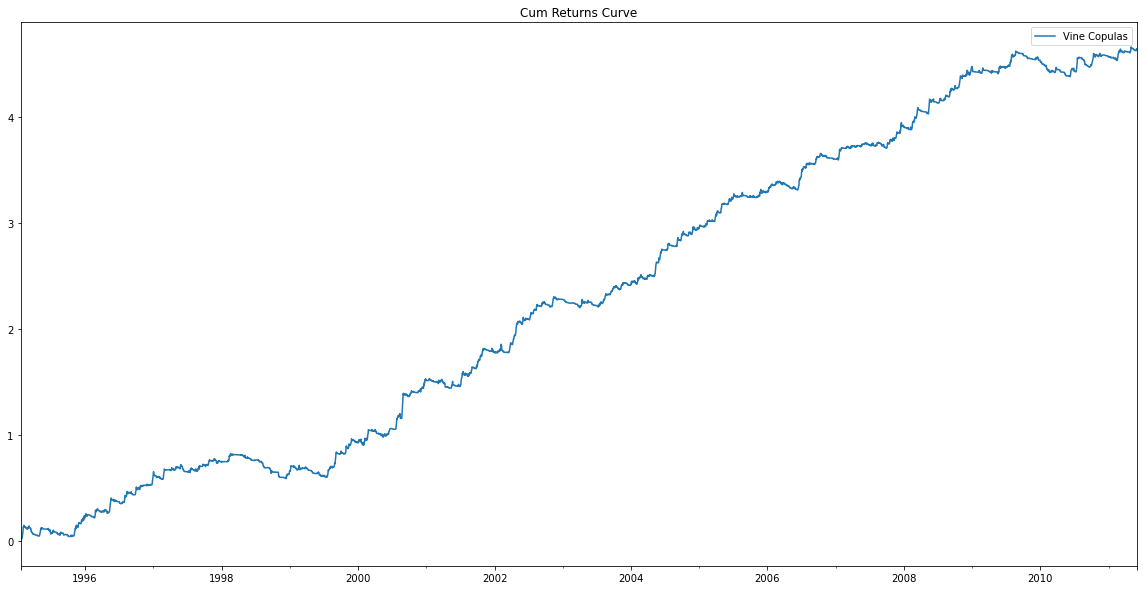

In [191]:
np.log((data_train['ecdf_rets'] + 1).cumprod()).plot(figsize=(20, 10))
plt.title('Cum Returns Curve')
plt.legend(['Vine Copulas'])
plt.show()